# Cohort Extraction: Critically Ill Trauma Patients

This study extracts a cohort of critically ill trauma patients from the MIMIC-III v1.4 dataset, applying stringent criteria including age range, admission duration, and mechanical ventilation days, as detailed in Section 3.1 "Cohort Extraction: Critically Ill Trauma Patients" of our paper. The refined cohort, tailored for studying early sepsis onset detection, comprises 1,570 admissions.

**Note**:

This notebook assumes that you have access to MIMIC-III v1.4 on Google BigQuery. If you are not sure or would like to apply for access, please refer to the `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.




# Environment Set Up

## Mount Google Drive
Considering that the overall process may take a long time and Colab execution may be interrupted, we highly recommend mounting your Google Drive to Colab to save intermediate results.

In [1]:
from google.colab import drive
drive.mount('/content/drive') #give access to Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [2]:
# Import libraries
import os
import re   # the regular expressions module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date

In [3]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/REED"
if not os.path.exists(BASE_PATH):
    raise OSError(f"Error: BASE_PATH '{BASE_PATH}' does not exist. Please update this variable to your own path.")

In [4]:
%cd {BASE_PATH}/SepsisOnset_TraumaCohort
from src.data import data_utils, sql2df, data_fetcher

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'%s/SepsisOnset_TraumaCohort'%BASE_PATH)

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort


# Table Loading and Data Preparation


## Qualified ICD9 E-code

ICD-9 codes, specifically E-codes, are a subset of the International Classification of Diseases, 9th Revision, that provide detailed information about external causes of injuries and poisoning. These codes are crucial for identifying trauma patients, as they capture the circumstances of injuries, such as falls, vehicle accidents, or other external causes.

*In our study*, we use a carefully curated list of 740 E-codes to extract a cohort of trauma patients from the MIMIC-III dataset. This process ensures that we include only those patients whose injuries are relevant to our post-traumatic sepsis study, while excluding unrelated cases such as poisonings. For example, E-codes related to poisoning (e.g., E850-E854) are excluded. By using these specific E-codes, we can accurately identify and analyze patients who are most likely to develop sepsis following traumatic injuries.

The full list of ICD9-Ecodes used includes:

> E8000-E8480, E8800-E9057, E9060-9259, E9270-E9289, E9507, E9520, E9521, E9520-E9589, E9600, E9610-E9689, E9680-E9689, E9700-E9760, E9780-E9799, E9806, E9830-E9886, E9888, E9889, E9900-E9961, and E9968-E9989.

More details can be found at `'supplementary/qualified_traumatic_ICD9_Ecodes.xlsx'`.



In [5]:
def select_ICDcode_df(project_path_obj, #Saved File Paths
                      project_id,       #Source File
                      ):
	'''
    Select trauma patients according to E-codes of ICD9_CODE.

    Parameters:
    - project_path_obj: An object containing paths to project-related files.
    - project_id: The Google BigQuery project ID for querying the MIMIC-III dataset.

    Returns:
    - DataFrame: A DataFrame containing patients' ICD9 diagnoses filtered by trauma E-codes.

    Notes:
    - This function reads a list of qualified traumatic injury E-codes from an Excel file located
      at 'supplementary/qualified_traumatic_ICD9_Ecodes.xlsx'.
    - The E-codes are reformatted to match the format used in the MIMIC-III dataset.
    - Queries the MIMIC-III clinical database to select all ICD diagnoses where ICD9_CODE is not NULL.
    - Filters the diagnoses to include only those starting with 'E' and matching the qualified trauma E-codes.
	'''
	# HMC's list of traumatic injury E-codes.
  # Detail saved at "supplementary/qualified_traumatic_ICD9_Ecodes.xlsx"
	ICD9Code_file_path = os.path.join(project_path_obj.get_supplementary_file("qualified_traumatic_ICD9_Ecodes.xlsx"))
  # print(ICD9Code_file_path)
	df_hmc_e = pd.read_excel(ICD9Code_file_path, sheet_name="Ecodes ICD 9")
  # Reformat the codes to be consistent with MIMIC's format.
	df_hmc_e["Ecode"] = df_hmc_e["Ecode"].apply(lambda x: "E" + re.sub(r'\W+', '', str(x)))
	Ecodes = df_hmc_e["Ecode"].unique()

	# select all ICD diagnoses where ICD9_CODE is not NULL
	query =  """
	SELECT *
	FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
	WHERE ICD9_CODE IS NOT NULL;
	"""
	ICDDIAGNOSES_df = data_utils.run_query(query, project_id)

	# select "ICD9_CODE" starting with E
	trum_df = ICDDIAGNOSES_df[ICDDIAGNOSES_df['ICD9_CODE'].str.startswith('E')]
	trum_df.loc[:, "ICD9_CODE"] = trum_df.loc[:, "ICD9_CODE"].apply(lambda e: str(e)+"0" if len(str(e)) < 5 else e)

	# Select all E-code diagnoses.
	trum_df = trum_df[trum_df['ICD9_CODE'].isin(Ecodes)]

	return trum_df
df = select_ICDcode_df(project_path_obj, PROJECT_ID)
print(df.shape)
# df.head()

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/data_utils.py:20: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


(6423, 5)


In [6]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
306,85880,7680,171514,2,E8889
322,88912,7936,102376,15,E8889
337,88927,7936,126501,9,E8889
513,106263,9472,166597,9,E8231
517,109017,9728,118635,4,E8131


## Demographics
In this section, we focus on extracting demographic information from the MIMIC-III dataset, which includes crucial patient details such as age and length of hospital stay.


In [7]:
# from src.data import sql2df

# Check if the demographics CSV file exists
demog_path = project_path_obj.get_raw_data_file('demographics.csv')
if os.path.exists(demog_path):
    # Load the CSV file into a DataFrame
    demog_df = pd.read_csv(demog_path, index_col=0)
else:
    # Query demographics information using BigQuery and save the results
    demog_df = sql2df.demog_sql2df(PROJECT_ID, saved_path=demog_path)

# Display the first 5 rows of the demographics DataFrame
demog_df.head(5)

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/data_utils.py:20: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


File saved at: /content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/data/raw/demographics.csv


,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital_days,los_hospital_hours,admission_age,...,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu_days,los_icu_hours,icustay_seq,first_icu_stay
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,4,92,0,...,asian,0,1,True,2138-07-17 21:20:07,2138-07-17 23:32:21,0,2,1,True
1,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,11,258,76,...,white,0,1,True,2101-10-20 19:10:11,2101-10-26 20:43:09,6,145,1,True
2,4,185777,294638,F,NaT,2191-03-16 00:28:00,2191-03-23 18:41:00,7,186,48,...,white,0,1,True,2191-03-16 00:29:31,2191-03-17 16:46:31,1,40,1,True
3,5,178980,214757,M,NaT,2103-02-02 04:31:00,2103-02-04 12:15:00,2,56,0,...,asian,0,1,True,2103-02-02 06:04:24,2103-02-02 08:06:00,0,2,1,True
4,6,107064,228232,F,NaT,2175-05-30 07:15:00,2175-06-15 16:00:00,16,393,66,...,white,0,1,True,2175-05-30 21:30:54,2175-06-03 13:39:54,4,88,1,True


## Ventilation

Ventilation days refer to the count of days during which a patient receives mechanical ventilation, irrespective of the hours spent ventilated each day. This metric is essential for identifying critically ill patients within our cohort. Patients requiring prolonged mechanical ventilation are more likely to have severe medical conditions, making them suitable candidates for studying complications like sepsis onset. By focusing on patients with extended ventilation periods, we aim to isolate a subset of the cohort that exhibits characteristics relevant to our research on early sepsis detection among trauma patients.

In [8]:
def ventilation_day_processed(project_id, vent_type=['MechVent'], saved_path=None):
  '''
  Identify the presence of mechanical ventilation
  - Based on source file: [ventilation_classification.sql](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/durations/ventilation_classification.sql)

  Compute the number of days the patient (HADM_ID) was receiving ventilation events
  - Regardless of how many hours in that day the patient received ventilation

  Parameters:
    project_id: BigQuery MIMIC-III Project ID
    vent_type: A subset of 4 ventilation types ['MechVent', 'OxygenTherapy', 'Extubated', 'SelfExtubated'].
              This function only counts the ventilation types within this subset.
              By default, only 'MechVent' will be considered a qualifying ventilation event.
  '''
  # Identify the presence of a mechanical ventilation using settings
  vent_df = data_utils.run_query(
      """
      SELECT i.hadm_id, v.*
      FROM `physionet-data.mimiciii_derived.ventilation_classification` v
      JOIN `physionet-data.mimiciii_clinical.icustays` i
      ON v.ICUSTAY_ID = i.ICUSTAY_ID;
      """, project_id)

  # Select qualified ventilation event according to vent_type
  vent_df['sum'] = vent_df[vent_type].sum(axis=1)
  qualified_vent_df = vent_df[vent_df['sum']>0]
  numevent = qualified_vent_df.shape[0]
  # Get date
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date
  vent_day_df = qualified_vent_df[['hadm_id', 'date_count']].drop_duplicates()
  # Count ventilation days: if a patient get ventilation (regaless of specific hours), then +1
  vent_day_count = vent_day_df.groupby('hadm_id').date_count.count().reset_index()
  if saved_path is not None:
    vent_day_count.to_csv(saved_path)
  return vent_day_count


In [9]:
from src.data.sql2df import ventilation_day_processed

# get ventilation day table
vent_path = project_path_obj.get_processed_data_file('MVday.csv')
if os.path.exists(vent_path):
    vent_df = pd.read_csv(vent_path, index_col=0)
else:
    vent_df = ventilation_day_processed(PROJECT_ID, vent_type=['MechVent'], saved_path=vent_path)

print(vent_df.shape)
# vent_df.head() # one row per patient

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/data_utils.py:20: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(
/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/sql2df.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date


Saved mechanical ventilation day at /content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/data/processed/MVday.csv
(26761, 2)


In [17]:
vent_df.head()

,hadm_id,date_count
0,100006,1
1,100009,1
2,100011,10
3,100012,2
4,100016,5


# Cohort Extraction

Rationale for Critically Ill Trauma Patients Cohort Criteria:
* Qualified HADM_ID:
> Use **HADM_ID** as the instance ID. Qualified HADM_IDs are defined as those with corresponding **CHARTEVENTS** data and at least one **ICUStay_ID**. The CHARTEVENTS table holds essential patient information during their hospital stay, including vital signs, ventilator settings, laboratory values, code status, and mental status.

* ICD-9 E-codes Selection:
> We select trauma patients based on specific E-codes of ICD-9 codes, focusing on injuries that are directly related to trauma scenarios. This ensures that our cohort comprises patients whose conditions are relevant to trauma-induced complications and outcomes. More details can be found at 'supplementary/qualified_traumatic_ICD9_Ecodes.xlsx'.

* Age Criteria (18-89 years):
>Limiting the age range to adults between 18 and 89 years helps to define a consistent study population that encompasses adult trauma patients. This age range is chosen to exclude pediatric cases while adhering to the standard definition of adult patients in medical research. The upper bound of 89 is used because, in the MIMIC-III dataset, any patient older than 89 is recorded as being 300 years old to protect patient privacy, making it difficult to accurately analyze patients beyond this age [(PhysioNet, 2016)](https://physionet.org/content/mimiciii/1.4/).

* Hospital Stay Duration (≥48 hours):
> Including patients with a hospital stay duration of at least 48 hours filters out cases where patients may have been discharged too quickly to gather meaningful data relevant to our study objectives. Our focus in on hospital-acquired, post-traumatic sepsis. Since hospital-acquired infections, by CDC definition, occur ≥ 48 hours after admission, we do not need to include patients who are in the hospital for < 48 hours.

* Ventilation Days (≥3):
> Ventilation days count the number of days a patient received mechanical ventilation, regardless of the hours per day. This metric helps identify patients at higher risk for sepsis, particularly those who require at least 3 days of ventilation. Research indicates that patients ventilated for fewer than 72 hours are at a much lower risk of infection, which can make predicting rare events like sepsis more challenging in these cases, as observed in previous literature [(Stern et al., 2023)](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2800552).



In [10]:
from src.data.data_fetcher import get_demographics_data, get_ventilation_data

In [11]:
def extract_trauma_cohort_ids(project_path_obj, # Saved File Paths
                              project_id,       # Source File
                              vent_threshold=3,
                              is_report=False,
                              is_saved=False):
  """
  Cohort Selection Criteria:
    1. Get qualified HADM_ID (with corresponding CHARTEVENTS data and at least 1 ICUStay_ID)
    2. Select trauma patients according to E-codes of ICD9_CODE
    3. Age between [18, 89]
    4. Hospital stay duration between [48 hours, None)
    5. Ventilation days >= 3
       Ventilation Days (vent_threshold):
          -> If None, the mechanical ventilation filter is not applied.
          -> If an integer, specifies the lower bound for the filter.
          -> This boundary is experimental.
          -> In Stern's paper, they used 3 as the threshold
             (Stern K, Qiu Q, Weykamp M, O’Keefe G, Brakenridge SC.
             Defining Posttraumatic Sepsis for Population-Level Research.
             JAMA Netw Open. 2023;6(1):e2251445. doi:10.1001/jamanetworkopen.2022.51445
             )
  """
  # Get qualified patients' demographics: (with corresponding CHARTEVENTS data and at least 1 ICUStay_ID)
  demog_df = get_demographics_data(project_path_obj, project_id)
  demog_df = demog_df[['subject_id', 'hadm_id', 'icustay_id',
                       'admission_age', 'admittime', 'dischtime',
                       'los_hospital_hours', 'los_hospital_days', 'hospital_expire_flag']]
  count_df = demog_df[['subject_id', 'hadm_id', 'icustay_id']].nunique().to_frame(name='TOTAL')

  # Selected according to E-codes.
  # Group by IDs and aggregate ICD9_CODE info to ensure unique patient IDs.
  TRUM_df = select_ICDcode_df(project_path_obj, project_id).groupby(['SUBJECT_ID', 'HADM_ID'])['ICD9_CODE'].agg(set).reset_index()
  TRUM_df = demog_df[demog_df['hadm_id'].isin(TRUM_df.HADM_ID)]

  # Filter according to the age in range [18, 89]
  TRUM_df_age = TRUM_df[(TRUM_df.admission_age >= 18) & (TRUM_df.admission_age <= 89)]

  # Filter according to the HADM duration in range [48h, NO upper bound)
  TRUM_df_los = TRUM_df_age[TRUM_df_age.los_hospital_hours >= 48]
  count_df['TRUM basic filter'] = TRUM_df_los[['subject_id', 'hadm_id', 'icustay_id']].nunique()

  # Select accoring to Ventilation Days
  if vent_threshold == None:
    trum_df = TRUM_df_los
  else:
    # Get ventilation day table
    vent_day_count = get_ventilation_data(project_path_obj, project_id)
    # Select according to Ventilation days >= vent_threshold (default is 3) for each patient
    TRUM_df_vent = TRUM_df_los.merge(vent_day_count, on='hadm_id', how='left')
    trum_vent_day_count = TRUM_df_vent[['hadm_id','date_count']].drop_duplicates()
    TRUM_df_vent = TRUM_df_vent[TRUM_df_vent['date_count'] >= vent_threshold]
    count_df['TRUM Vent filter'] = TRUM_df_vent[['subject_id', 'hadm_id', 'icustay_id']].nunique()
    trum_df = TRUM_df_vent

  ## Statistics ##
  if is_report:
    display(count_df)
    print("MIMIC III includes: %d (qualified hospital admissions)" % demog_df.hadm_id.nunique())
    print("After Trauma Selection (ICD-9): %d" % TRUM_df.hadm_id.nunique())
    print("After Age Filter: %d" % TRUM_df_age.hadm_id.nunique())

    TRUM_df_firstfewday = TRUM_df_age.loc[TRUM_df_age.los_hospital_hours < 48, ['hadm_id', 'hospital_expire_flag']].drop_duplicates()
    TRUM_df_firstfewday_mortalitycount = TRUM_df_firstfewday.hospital_expire_flag.value_counts()

    # print("After Hospital Length of Stay >= 48h Filter: %d" % TRUM_df_los.hadm_id.nunique())
    print("After Hospital Length of Stay Filter (>= 48 hours): %d" % TRUM_df_los.hadm_id.nunique())
    print("\tHospital Length of Stay < 48h: %d = %d (Died) + %d (Discharged Alive)" %
          (TRUM_df_firstfewday.shape[0], TRUM_df_firstfewday_mortalitycount[1], TRUM_df_firstfewday_mortalitycount[0]))

    if vent_threshold is not None:
        num_not_intubated = trum_vent_day_count.date_count.isna().sum()
        intubated_less_thr = trum_vent_day_count[trum_vent_day_count.date_count < vent_threshold].shape[0]
        print('Mechanical Ventilation Day Filter: \n\t%d (Not Intubated) + %d (Intubated < %d days)' %
              (num_not_intubated, intubated_less_thr, vent_threshold))
    print("Final Cohort Size: %d" % trum_df.hadm_id.nunique())

  if is_saved:
    print("Save to: ", project_path_obj.trauma_cohort_info_path)
    trum_df.to_csv(project_path_obj.trauma_cohort_info_path)
  return trum_df

In [12]:
# Default config: with Mechanical Ventilation day >=3 day filter
trum_ids = extract_trauma_cohort_ids(project_path_obj, PROJECT_ID,
                                     vent_threshold=3,
                                     is_report=True, is_saved=True)

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/data_utils.py:20: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,1551
hadm_id,57328,4977,1570
icustay_id,61051,5410,1828


MIMIC III includes: 57328 (qualified hospital admissions)
After Trauma Selection (ICD-9): 6148
After Age Filter: 5651
After Hospital Length of Stay Filter (>= 48 hours): 4977
	Hospital Length of Stay < 48h: 674 = 200 (Died) + 474 (Discharged Alive)
Mechanical Ventilation Day Filter: 
	2271 (Not Intubated) + 1136 (Intubated < 3 days)
Final Cohort Size: 1570
Save to:  /content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/data/processed/trauma_cohort_info.csv


In [19]:
trum_ids.head()

,subject_id,hadm_id,icustay_id,admission_age,admittime,dischtime,los_hospital_hours,los_hospital_days,hospital_expire_flag,date_count
0,43,146828,225852,33,2186-10-01 23:15:00,2186-10-11 18:00:00,235,10,0,4.0
9,141,168006,234668,80,2140-11-06 11:07:00,2140-11-09 20:36:00,81,3,1,4.0
11,147,103631,252947,25,2158-06-24 18:50:00,2158-07-21 14:10:00,644,27,0,6.0
15,179,161310,256090,30,2173-05-26 02:01:00,2173-06-05 12:45:00,250,10,0,8.0
17,188,164735,284015,56,2161-07-01 19:44:00,2161-07-10 20:00:00,217,9,0,3.0


### Understanding patient identification in MIMIC-III dataset

In the MIMIC-III dataset, three primary identifiers distinguish different stages of patient care: SUBJECT_ID, HADM_ID, and ICUSTAY_ID.

1. **SUBJECT_ID:**
   - **Definition:** It uniquely identifies each patient in the dataset.
   - **Usage:** A SUBJECT_ID remains constant for a patient across all their hospital visits and ICU stays. Multiple hospital admissions and ICU stays can be associated with the same SUBJECT_ID.

2. **HADM_ID:**
   - **Definition:** It uniquely identifies each hospital admission for a patient.
   - **Usage:** Each hospital stay for a patient is assigned a unique HADM_ID. Multiple hospital admissions can belong to the same SUBJECT_ID, indicating repeated hospital visits by the same patient.

3. **ICUSTAY_ID:**
   - **Definition:** It uniquely identifies each ICU stay within a hospital admission.
   - **Usage:** An ICUSTAY_ID is specific to a patient's stay in the ICU during a hospital admission. Multiple ICU stays can occur within the same hospital admission, each with its own ICUSTAY_ID.


### Selection of HADM_ID as the Instance ID

- **Suitability of HADM_ID:** HADM_ID is chosen as the instance ID in our study because it represents a discrete episode of hospitalization, which aligns with the traditional concept of patient care episodes in clinical research. It encapsulates all medical interventions and observations made during a specific hospital admission, making it a coherent unit of analysis.

- **Clinical Relevance:** Researchers often focus on hospital admissions (identified by HADM_ID) to study patient outcomes and interventions because each admission typically represents a distinct medical event or treatment course. This approach allows for better tracking and analysis of patient trajectories and outcomes within the hospital setting.




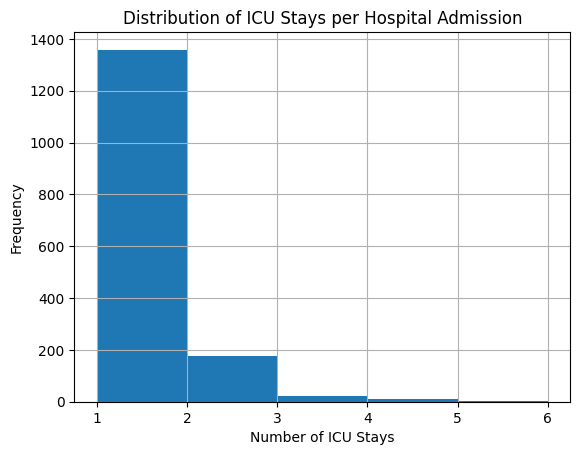

In [13]:
# One hospital admission may have multiple ICU stays
# Most hospital admissions only have one ICU stay
trum_ids.groupby('hadm_id').icustay_id.nunique().hist(bins=[1, 2, 3, 4, 5, 6])

# Add title to the histogram
plt.title('Distribution of ICU Stays per Hospital Admission')

# Optionally, add labels to the axes
plt.xlabel('Number of ICU Stays')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Library-Based Cohort Extraction



This section shows how to use the function to achieve the same cohort extraction process in a more streamlined and reusable manner. The function is imported from a Python file, and the output is compared to ensure consistency with the previous section.

In [14]:
# BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing" # Remember to update this variable to your own path
# %cd $BASE_PATH/Post_Traumatic_Sepsis_MIMICIII
# !ls

In [15]:
# Initialize the ProjectPaths object with the full path to the Post_Traumatic_Sepsis_MIMICIII directory.
# BASE_PATH is where the GitHub project was cloned.
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/SepsisOnset_TraumaCohort')
# Set the environment variable for the BigQuery project ID.
PROJECT_ID = 'sepsis-mimic3' # SET YOUR PROJECT ID

from scripts.cohort_extraction import extract_trauma_cohort_ids
# Extract cohort IDs and generate a statistics report
trum_ids = extract_trauma_cohort_ids(
    project_path_obj,  # Saved file paths
    PROJECT_ID,        # To query raw data
    is_report=True     # Print statistics report
)

/content/drive/MyDrive/REED/SepsisOnset_TraumaCohort/src/data/data_utils.py:20: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,1551
hadm_id,57328,4977,1570
icustay_id,61051,5410,1828


MIMIC III includes: 57328 (qualified hospital admissions)
After Trauma Selection (ICD-9): 6148
After Age Filter: 5651
After Hospital Length of Stay >= 48h Filter: 4977
	Hospital Length of Stay < 48h: 674 = 200 (Died) + 474 (Discharged Alive)
Mechanical Ventilation Day Filter: 
	2271 (Not Intubated) + 1136 (Intubated < 3 days)
Final Cohort Size: 1570


**Note:**
The first time running the above block may take about 7 minutes.




# References

* PhysioNet. (2016, September 4). **MIMIC-III Clinical Database: Issue #144**. Version 1.4. Retrieved from [https://physionet.org/content/mimiciii/1.4/](https://physionet.org/content/mimiciii/1.4/)

* Stern, K., Qiu, Q., Weykamp, M., O’Keefe, G., & Brakenridge, S. C. (2023). Defining posttraumatic sepsis for population-level research. *JAMA Network Open, 6*(1), e2251445. https://doi.org/10.1001/jamanetworkopen.2022.51445